In [5]:
### fix how M values is taken in
# Switch to Jupyter Notebook
# Import Data
# Make a special data file with only 10 events or so
# Plot the raw signals from those 10 events
# Plot resulting Trapezoids
# Plot energy spectrum of those 10
# figure out calibration
# Plot the full, calibrated energy spectra for Co, Cs, Am (to check for re-takes)
# Fit peaks and get FWHM Values
# Plot FWHM vs gap time
# Plot FWHM vs peak time
# Set optimal peak and gap times and save spectrum
# Make electronic noise plot
# calculate FANO factor
# Write text
# What else?

# REDO DATA Cs = low stats, Co maybe okay, Am/ Co peaks?/ pulser?

In [6]:
from __future__ import division, print_function
from numba import jit
from math import floor
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import tables
import sys

In [307]:
@jit(parallel = True)
def baseline_correction(data):
    n_data = len(data)
    baseline_correction_value = np.mean(data[0:799])
    for i in range(0, n_data, 1):
        data[i] = data[i] - baseline_correction_value
    return data

def test_baseline_correction():
    data = []
    for i in range(0, 800, 1): # TODO NOT WORKING
        data.append(100)
    for i in range(800, 810, 1):
        data.append(500)
    data = baseline_correction(data)
    assert data[10] == 0

def pz_correction(data, tau):
    pz_corrected = []
    pz_correction = []
    for i in range(0, n_data, 1):
        pz = np.sum(data[1:i-1])
        pz_correction.append(pz)
        pz_corrected.append(data[i] + pz / tau)
    return pz_corrected

# def trapezoidal_filter(data, gap_time, peaking_time):
#     m = gap_time
#     k = peaking_time
#     l = peaking_time + gap_time
#     filtered_signal = [0]*4096
#     for j in range(k + 1, k + m, 1):
#         sig = np.sum(data[j - k: j])
#         filtered_signal[j] = sig
#     for j in range(k + l + 1, n_data, 1):
#         sig = np.sum(data[j - k: j]) - np.sum(data[j - l - k: j - l])
#         filtered_signal[j] = sig
#     return filtered_signal

def find_M_value(data, num):
    tau_values = []
    for i in range(0, num, 1):
        signal = raw_data[2,:]
        x = np.asarray(range(np.argmax(signal), n_data, 1))
        y = np.asarray(signal[np.argmax(signal):n_data])
        out = FitExponential(x, y)
        tau_values.append(out['exp_decay'].value)
    tau = np.mean(tau_values)
    return tau

@jit(parallel = True)
def trapezoidal_filter(signal, m, k, M):
    sum_3 = np.zeros(len(signal), dtype=np.float32)
    sum_4 = np.zeros(len(signal), dtype=np.float32)
    acc_1 = np.zeros(len(signal), dtype=np.float32)
    acc_2 = np.zeros(len(signal), dtype=np.float32)

    for i in range(2 * k + m, len(signal)):  # following block diagram in Jordanov paper
        sum1 = signal[i] - signal[i - k]
        sum2 = signal[i - k - m - k] - signal[i - k - m]
        sum_3[i] = sum1 + sum2
        acc_1[i] = sum_3[i] + acc_1[i - 1] # S(n-1) + sum3(n)
        sum_4[i] = acc_1[i] + M * sum_3[i] #PZ correction?? same?
        acc_2[i] = sum_4[i] + acc_2[i-1]
    return acc_2

@jit(parallel = True)
def get_energy_value(data): # TODO
    energy = max(data)
    return energy

def get_time_values(length_of_data, sampling_time):
    time_values = np.linspace(0, length_of_data * sampling_time, length_of_data)
    return time_values

def FitExponential(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    # print(out.fit_report())
    # plt.figure()
    # plt.plot(x, y, 'o')
    # plt.plot(x, out.best_fit, 'r--')
    # plt.show()
    return out.params

def filter_and_get_energy(signal, peak, gap, M):
    signal = baseline_correction(signal)
    signal = trapezoidal_filter(signal, gap, peak, M)
    energy_value = get_energy_value(signal)
    energy_value = round(energy_value, 7)
    #energy_value = energy_value / 440000
    return energy_value

def FitGaussianWithPlot(x, y):
    mod = lmfit.models.GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report(min_correl=0.25))
    plt.plot(x, y, 'bo')
    plt.plot(x, out.init_fit, 'k--')
    plt.plot(x, out.best_fit, 'r-')
    plt.show()
    fwhm = out.params['fwhm'].value
    center = out.params['center'].value
    return fwhm, center
    

def FitGaussianPeakLinearBackground(x, y, peak_amplitude, peak_centroid, peak_sigma):

    peak_amplitude = int(peak_amplitude)
    peak_centroid = int(peak_centroid)
    peak_sigma = int(peak_sigma)

    bkg_mod = lmfit.models.LinearModel(prefix='lin_')
    pars = bkg_mod.guess(y, x=x)

    gauss1 = lmfit.models.GaussianModel(prefix='g1_')
    pars.update(gauss1.make_params())

    pars['g1_center'].set((peak_centroid), min=(peak_centroid - 200), max=(peak_centroid + 200))
    pars['g1_sigma'].set(peak_sigma, min=0.1)
    pars['g1_amplitude'].set(peak_amplitude, min=10)

    #gauss2  = GaussianModel(prefix='g2_')
    #pars.update(gauss2.make_params())
    #pars['g2_center'].set(155, min=125, max=175)
    #pars['g2_sigma'].set(15, min=3)
    #pars['g2_amplitude'].set(2000, min=10)

    mod = gauss1 + bkg_mod
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

    comps = out.eval_components(x=x)

    #print("fwhm:")
    fit_fwhm = (out.params['g1_fwhm'].value)
    fit_fwhm_err = (out.params['g1_fwhm'].stderr)
    fit_center = (out.params['g1_center'].value)
    fit_sigma = (out.params['g1_sigma'].value)
    fit_height = (out.params['g1_height'].value)
    print("=========FIT HEIGHT=========")
    print(fit_height)
    fit_amplitude = (out.params['g1_amplitude'].value)
    chisqr = out.chisqr
    redchi = out.redchi

    print(out.fit_report(min_correl=0.5))

    plt.figure(figsize=(10, 5))

    plt.axis([(out.params['g1_center'].value - 2 * out.params['g1_fwhm'].value), (out.params['g1_center'].value + 2 * out.params['g1_fwhm'].value), 0, (1.2 * out.params['g1_height'].value)])
    ax = plt.gca()
    ax.set_autoscale_on(False)

    plt.plot(x, y, 'bo')
    plt.plot(x, out.init_fit, 'k--')
    plt.plot(x, out.best_fit, 'r-')
    plt.plot(x, comps['g1_'], 'b--')
    #plt.plot(x, comps['g2_'], 'b--')
    plt.plot(x, comps['lin_'], 'g--')

    myfile = open('testfile.txt', 'w')
    myfile.write(out.fit_report())
    myfile.close()

    #   plt.plot(x, y, 'bo')
    #   plt.plot(x, out.init_fit, 'k--')
    #   plt.plot(x, out.best_fit, 'r-')
    plt.show()

    return fit_fwhm, fit_fwhm_err, fit_center, fit_sigma, fit_height, fit_amplitude, chisqr, redchi

def ImportData(filename):
    # open file
    hf = tables.open_file(filename, "r")
    event_data = hf.root.EventData.read()
    raw_data = hf.root.RawData.read()
    hf.close()
    #h5file = tables.open_file("sample.h5", mode="w")

    # mask retriggered events
    mask = (event_data['retrigger'] == 1)
    raw_data[mask] = 0
    return raw_data

In [308]:
def GetBinCentersFromEdges(edges):
    edges = np.array(edges)
    centers = (edges[:-1] + edges[1:]) / 2
    return centers

def selectROI():
    lowindex = raw_input("ROI low index (channel #)")
    #lowindex = 8000
    if lowindex == '':
        lowindex = 0
    highindex = raw_input("ROI high index (channel #)")
    #highindex = 11000
    if highindex == '':
        highindex = spec.channels(max)
    lowindex = int(lowindex)
    highindex = int(highindex)
    return lowindex, highindex

def FitGaussian(x,y):
    
    mod = lmfit.models.GaussianModel()
    
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    fwhm = out.params['fwhm'].value
    center = out.params['center'].value
    
    #plt.plot(x, y, 'bo')
    #plt.plot(x, out.init_fit, 'k--')
    #plt.plot(x, out.best_fit, 'r-')
    #plt.show()
    return fwhm, center


In [15]:
# if __name__ == "__main__":

In [16]:
# filename = 'data/co60.h5'
filename = 'data/DATA_co60_2.h5'
raw_data = ImportData(filename)

In [17]:
print('len ', len(raw_data))
sampling_time = 10.0
n_data = 4096
x_values = np.linspace(0, n_data, n_data)

len  31908


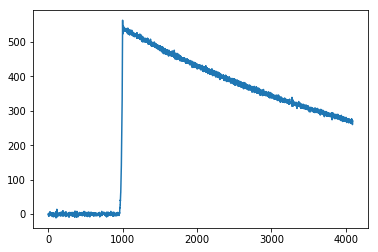

In [28]:
raw_signal = raw_data[2,:]
M = find_M_value(raw_data, 100)
signal = baseline_correction(raw_signal)
plt.plot(signal)
plt.show()

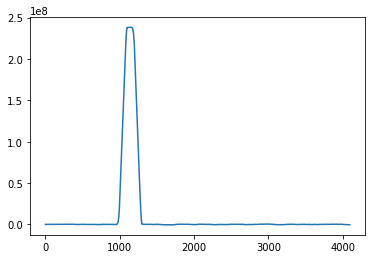

In [29]:
peaking_time = 100 
gap = 100 
M = 4400
filtered_signal = trapezoidal_filter(signal, gap, peaking_time, M)
plt.figure(41)
plt.cla()
plt.clf()
plt.plot(x_values, filtered_signal)
plt.show()

In [32]:
energy = get_energy_value(filtered_signal)
print(energy)

2.38403e+08


In [57]:
nrgs = []

number_of_events = len(raw_data)
assert number_of_events <= len(raw_data)

k = 100 # peaking time
l = 100 # gap
M = 4400

for i in range(0, number_of_events, 1):
    signal = raw_data[i,:]
    nrg = filter_and_get_energy(signal, l, k, M)
    nrgs.append(round(nrg, 7))

max  9246273536.0
min  0.0


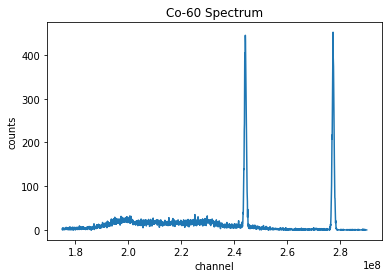

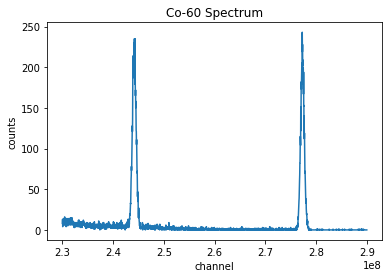

In [191]:
nbins = 2048
counts, bin_edges = np.histogram(nrgs, bins=2048, range=[1.75e8, 2.9e8]) #range=[2.3e8, 2.9e8] WORKS
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.figure()
plt.plot(bins, counts)
plt.title('Co-60 Spectrum')
plt.ylabel('counts')
plt.xlabel('channel')
plt.savefig('./co60.pdf')
plt.show()

nbins = 2048
counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.figure()
plt.plot(bins, counts)
plt.title('Co-60 Spectrum')
plt.ylabel('counts')
plt.xlabel('channel')
plt.savefig('./co60.pdf')
plt.show()


In [192]:
def findpeaks(data_x, data_y, low_index, high_index):
    cut_data_y = data_y[low_index:high_index]
    for i in range (low_index,high_index):
        if data_y[i] == max(cut_data_y):
            centerindex =  data_x[i]
            minindex=low_index
            maxindex=high_index
            amplitude = max(cut_data_y)
    ROIrange = [minindex, maxindex]
    return centerindex, amplitude, minindex, maxindex

# def apply_calibration(self, cal):
#     n_edges = len(self.channels) + 1
#     channel_edges = np.linspace(-0.5, float(self.channels[-1] + 0.5), num=n_edges)
#     self.bin_edges_kev = cal.ch2kev(channel_edges)
#     return self.slope * ch + self.offset

def calculate_coefficients(calibration_channels, calibration_energies, polynomial_order):
    return np.polyfit(calibration_channels, calibration_energies, polynomial_order)

def calculate_energies(x, m, b):
    energies = m * x + b
    return energies

In [243]:
def calibrate_co_spectrum(nrgs):# Get first calibration point, ROI HARDCODED
    nbins = 2048
    counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    x = bins
    y = counts
    ROI_low =400
    ROI_high = 600
    centroidguess, amplitudeguess, ROIrangemin, ROIrangemax = findpeaks(x, y, ROI_low, ROI_high)
    fwhm1, center1 = FitGaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])
    
    ROI_low =1550
    ROI_high = 1700
    centroidguess, amplitudeguess, ROIrangemin, ROIrangemax = findpeaks(x, y, ROI_low, ROI_high)
    fwhm2, center2 = FitGaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])
    
    # from above fits:

    Co_energies = [1173.2, 1332.5] # MeV
    #Co_indices = [2.4416e+08, 2.7727e+08]
    Co_indices = [center1, center2]
    print (Co_indices)
    
    f = calculate_coefficients(Co_indices, Co_energies, 1)
    print(f)
    m = f[0]
    b = f[1]
    energies = calculate_energies(x, m, b)
    
    return energies


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 200
    # variables        = 3
    chi-square         = 9483.036
    reduced chi-square = 48.137
    Akaike info crit   = 777.788
    Bayesian info crit = 787.683
[[Variables]]
    sigma:       3.9768e+05 +/- 3.86e+03 (0.97%) (init= 395507.8)
    center:      2.4381e+08 +/- 3.86e+03 (0.00%) (init= 2.438281e+08)
    amplitude:   2.0561e+08 +/- 1.73e+06 (0.84%) (init= 2.669678e+08)
    fwhm:        9.3647e+05 +/- 9.08e+03 (0.97%)  == '2.3548200*sigma'
    height:      206.259319 +/- 1.732374 (0.84%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, amplitude)          =  0.577 



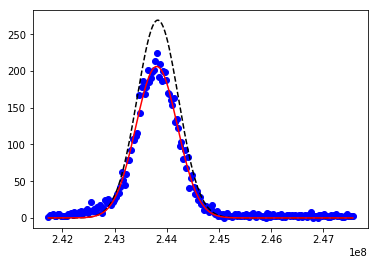

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 150
    # variables        = 3
    chi-square         = 8301.244
    reduced chi-square = 56.471
    Akaike info crit   = 608.029
    Bayesian info crit = 617.061
[[Variables]]
    sigma:       3.6946e+05 +/- 4.16e+03 (1.13%) (init= 366210.9)
    center:      2.7696e+08 +/- 4.16e+03 (0.00%) (init= 2.769629e+08)
    amplitude:   1.8496e+08 +/- 1.80e+06 (0.97%) (init= 2.416992e+08)
    fwhm:        8.7002e+05 +/- 9.79e+03 (1.13%)  == '2.3548200*sigma'
    height:      199.718546 +/- 1.946636 (0.97%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, amplitude)          =  0.577 



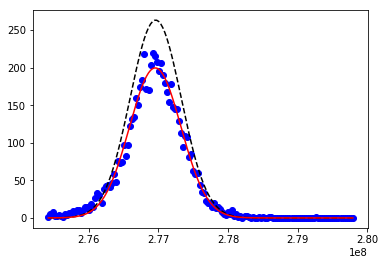

[243807779.4645904, 276956974.7552224]
[  4.80554652e-06   1.57037436e+00]


In [244]:
co_energies = calibrate_co_spectrum(nrgs)

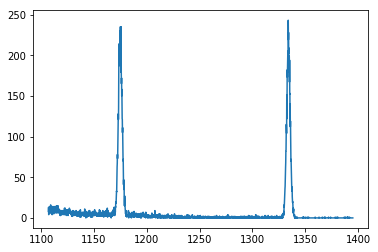

In [245]:
plt.plot(co_energies, counts)
plt.show()

In [328]:
def get_energy_resolution_co_1173(x, y):
    ROI_low =400
    ROI_high = 600
    centroidguess, amplitudeguess, ROIrangemin, ROIrangemax = findpeaks(x, y, ROI_low, ROI_high)
    fwhm, center = FitGaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])

    return fwhm, center

def get_energy_resolution_co_1332(x, y):
    i = int(np.argmax(y))
    ROI_low = int(i + 100)
    ROI_high =  2048
    centroidguess, amplitudeguess, ROIrangemin, ROIrangemax = findpeaks(x, y, ROI_low, ROI_high)
    fwhm, center =  FitGaussianWithPlot(x[ROI_low:ROI_high], y[ROI_low:ROI_high])

    return fwhm, center

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 198
    # data points      = 335
    # variables        = 3
    chi-square         = 20.550
    reduced chi-square = 0.062
    Akaike info crit   = -929.080
    Bayesian info crit = -917.637
[[Variables]]
    sigma:       516.095000 +/- 1.71e+05 (33091.17%) (init= 21.75521)
    center:      2703.50967 +/- 8.79e+05 (32531.44%) (init= 1370.684)
    amplitude:   2387.51113 +/- 5.91e+06 (247399.15%) (init= 65.26564)
    fwhm:        1215.31082 +/- 4.02e+05 (33091.17%)  == '2.3548200*sigma'
    height:      1.84555010 +/- 3.96e+03 (214309.20%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.250)
    C(center, amplitude)         =  1.000 
    C(sigma, center)             =  1.000 
    C(sigma, amplitude)          =  1.000 



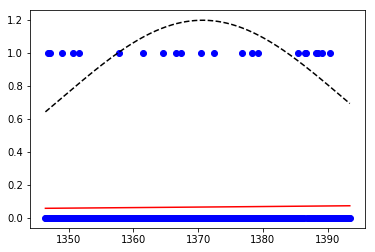

In [329]:
energy_values = []
fwhm_values = []

fwhm, center = get_energy_resolution_co_1173(energies, counts)
fwhm_values.append(fwhm)
energy_values.append(center)
fwhm, center = get_energy_resolution_co_1332(energies, counts)
fwhm_values.append(fwhm)
energy_values.append(center)

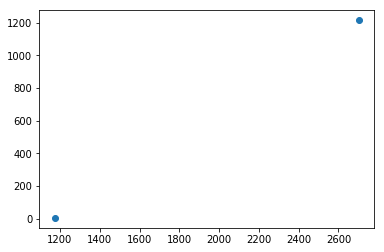

In [330]:
plt.plot(energy_values, fwhm_values, 'o')
plt.show()

10.0
[8889630.978233846, 269688497.0172923]
[  6.10815539e-07   1.16777008e+03]
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 1605
    # variables        = 3
    chi-square         = 12639.300
    reduced chi-square = 7.890
    Akaike info crit   = 3318.218
    Bayesian info crit = 3334.361
[[Variables]]
    sigma:       0.46357867 +/- 0.003097 (0.67%) (init= 0.4205322)
    center:      1334.65761 +/- 0.003097 (0.00%) (init= 1334.657)
    amplitude:   101.942862 +/- 0.589930 (0.58%) (init= 138.7756)
    fwhm:        1.09164433 +/- 0.007294 (0.67%)  == '2.3548200*sigma'
    height:      87.7290565 +/- 0.507675 (0.58%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, amplitude)          =  0.577 



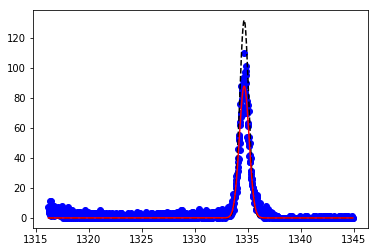

1000.0
[10020670.775795434, 269837996.79314685]
[  6.13123083e-07   1.16705610e+03]
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 1605
    # variables        = 3
    chi-square         = 12642.138
    reduced chi-square = 7.891
    Akaike info crit   = 3318.578
    Bayesian info crit = 3334.721
[[Variables]]
    sigma:       0.46538569 +/- 0.003110 (0.67%) (init= 0.4221209)
    center:      1334.57398 +/- 0.003110 (0.00%) (init= 1334.573)
    amplitude:   102.331814 +/- 0.592260 (0.58%) (init= 139.2999)
    fwhm:        1.09589954 +/- 0.007323 (0.67%)  == '2.3548200*sigma'
    height:      87.7218399 +/- 0.507701 (0.58%)  == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, amplitude)          =  0.577 



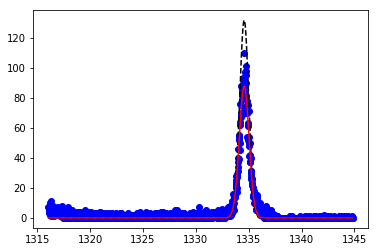

In [332]:
#k_values = np.linspace(500, 10000, 2) # steps in 100 ns from 1ns to 10us
m_values = np.linspace(0, 100000, 1000) # steps in 100 ns from 1ns to 10us

M = 4400

k_values = [100]
m_values = np.linspace(10, 1000, 2)
fwhm_values = []
m_values_ns = []
k = k_values[0]
for m in m_values:
    print(m)
    m_values_ns.append(m * 10)
    nrgs = []
    number_of_events = len(raw_data)
    assert number_of_events <= len(raw_data)

    for i in range(0, number_of_events, 1):
        signal = raw_data[i,:]
        nrg = filter_and_get_energy(signal, l, k, M)
        nrgs.append(round(nrg, 7))
        
    nbins = 2048
    co_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

    co_energies = calibrate_co_spectrum(nrgs)
    #fwhm, center = get_energy_resolution_co_1173(co_energies, co_counts)
    fwhm, center = get_energy_resolution_co_1332(co_energies, co_counts)
        
    fwhm_values.append(fwhm)
        

In [ ]:
#k_values = np.linspace(500, 10000, 2) # steps in 100 ns from 1ns to 10us
m_values = np.linspace(0, 100000, 1000) # steps in 100 ns from 1ns to 10us

M = 4400

k = 100
#m_values = np.linspace(1, 10000, 10)

fwhm_values = []
m_values_ns = []
index = []
for m in m_values:
    print(m)
    m_values_ns.append(m * 10)
    nrgs = []
    number_of_events = len(raw_data)
    assert number_of_events <= len(raw_data)

    for i in range(0, number_of_events, 1):
        signal = raw_data[i,:]
        nrg = filter_and_get_energy(signal, l, k, M)
        nrgs.append(round(nrg, 7))
        
    nbins = 2048
    co_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    index.append(np.argmax(co_counts))
   # co_energies = calibrate_co_spectrum(nrgs)
    #fwhm, center = get_energy_resolution_co_1173(co_energies, co_counts)
  #  fwhm, center = get_energy_resolution_co_1332(co_energies, co_counts)
        
  #  fwhm_values.append(fwhm)
        

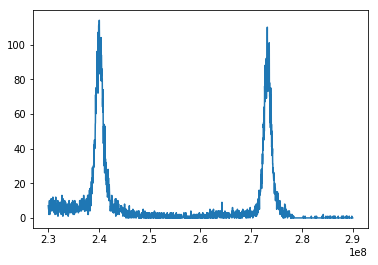

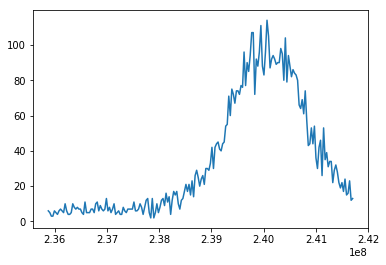

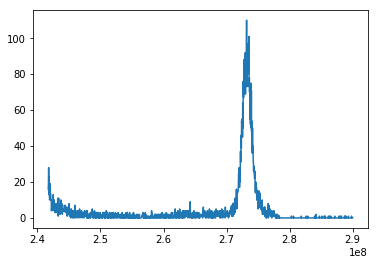

In [327]:
plt.plot(bins, co_counts)
plt.show()
plt.plot(bins[200:400], co_counts[200:400])
plt.show()
plt.plot(bins[400:], co_counts[400:])
plt.show()

In [ ]:
plt.plot(m_values, index, 'o')
plt.show()

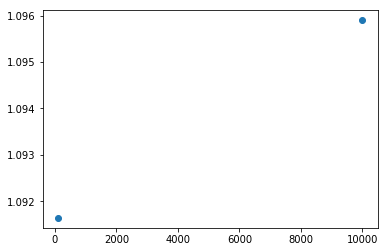

In [333]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.show()

In [ ]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.xlabel('gap time (ns)')
plt.title('variable gap with peaking time = 1')
plt.show()

In [ ]:
# END HERE STOP 

In [146]:
numberofROIs = int(raw_input('how many ROIs?'))
print (numberofROIs)
    
if numberofROIs < 1:
    print('no ROIs. Exiting...')
    sys.exit()
for i in range (0, (numberofROIs), 1):
    ROI_low, ROI_high = selectROI()
    centroidguess, amplitudeguess, ROIrangemin, ROIrangemax = findpeaks(spec.energies_kev, spec.counts_vals, ROI_low, ROI_high)
    plot_spectrum_raw(spec.energies_kev[ROI_low:ROI_high], spec.counts_vals[ROI_low:ROI_high])
    peakfwhm, peakfwhmerr, peakcenter, peaksigma, peakheight, peakamplitude = FitGaussianPeakLinearBackground(spec.energies_kev[ROIrangemin:ROIrangemax], spec.counts_vals[ROIrangemin:ROIrangemax], amplitudeguess, centroidguess, 1)
    print(peakcenter)
    sys.exit()

how many ROIs?


ValueError: invalid literal for int() with base 10: ''

In [61]:
#print(nrgs)
print(max(nrgs))
print(min(nrgs))

1107731.52388
38280.8694215


In [62]:
np.shape(nrgs)

(37,)

In [ ]:
plt.hist(nrgs, 500, range=(4e4, 8e4))
#plt.xlim([0, 200000])
plt.show()

In [73]:
@jit(parallel=True)
def baseline_correction(data):
    n_data = len(data)
    baseline_correction_value = np.mean(data[0:799])
    for i in range(0, n_data, 1):
        data[i] = data[i] - baseline_correction_value
    return data

def test_baseline_correction():
    data = []
    for i in range(0, 800, 1): # TODO NOT WORKING
        data.append(100)
    for i in range(800, 810, 1):
        data.append(500)
    data = baseline_correction(data)
    assert data[10] == 0

def exp_func(x,a,b):
    return a*np.exp(-x/b)
def fit_exponential(data):
    xdata = np.arange(len(data))
    ydata = np.array(data)
    fit,fit2 = opt.curve_fit(exp_func,xdata,ydata)
    return int(np.round(fit[1]))

@jit(parallel=True)
def pz_correction(data, tau):
    pz_corrected = []
    pz_correction = []
    for i in range(0, n_data, 1):
        pz = np.sum(data[1:i-1])
        pz_correction.append(pz)
        #tau = 30000
        pz_corrected.append(data[i] + pz / tau)
    return pz_corrected

@jit(parallel=True)
def trapezoidal_filter(data, gap_time, peaking_time):
    m = gap_time
    k = peaking_time
    l = peaking_time + gap_time
    filtered_signal = [0]*4096
    #print(filtered_signal[0:10])
    for j in range(k + 1, k + m, 1):
        sig = np.sum(data[j - k: j])
        filtered_signal[j] = sig
    for j in range(k + l + 1, n_data, 1):
        sig = np.sum(data[j - k: j]) - np.sum(data[j - l - k: j - l])
       # if j%1000 == 0:
       #     plt.plot(data)
       #     plt.plot(np.linspace(j-k, j, k), data[j - k: j], 'ob')
       #     plt.plot(np.linspace(j- l - k, j - l, k), data[j - l - k: j - l], 'or')
       #     plt.show()
        filtered_signal[j] = sig

    #print(filtered_signal[0:10])
    #print(filtered_signal[-10:-1])
    return filtered_signal

def get_energy_value(data): # TODO
    energy = max(data)
    return energy

def get_time_values(length_of_data, sampling_time):
    time_values = np.linspace(0, length_of_data * sampling_time, length_of_data)
    return time_values

In [74]:

@jit(parallel=True)
def trapezoidal_filter_2(data, gap_time, peaking_time):
    # ------- Apply exponential fit for the M multiplication --------------#
    # out = exp_fit(signal, plot_comps = None)
    # tau = out['exp_decay'].value #in nanoseconds
    # tau_std = out['exp_decay'].stderr
    # T_sp = 1 #nano seconds
    # M= tau
    # print('M ',M)
    ##---------Start of filter---------------------------#
    filtered_signal = [0]*4096  # 4096 = signal length in this data set, change as needed
    k = peaking_time
    m = gap_time

    M = 4400

    sum_3 = np.zeros(len(signal), dtype=np.float32)
    sum_4 = np.zeros(len(signal), dtype=np.float32)
    acc_1 = np.zeros(len(signal), dtype=np.float32)
    acc_2 = np.zeros(len(signal), dtype=np.float32)

    for i in range(2 * k + m, len(signal)):  # following block diagram in Jordanov paper
        sum1 = signal[i] - signal[i - k]
        sum2 = signal[i - k - m - k] - signal[i - k - m]
        sum_3[i] = sum1 + sum2
        acc_1[i] = sum_3[i] + acc_1[i - 1]
        sum_4[i] = acc_1[i] + M * sum_3[i]
        acc_2[i] = sum_4[i] + acc_2[i-1]

    return acc_2


def exp_fit(signal, plot_comps=None):
    '''
    out = exp_fit takes a range of data that and fits an exponential to the tail
    of the amplitude pulse returning the parameters of the peak
    with out.params

    To access the data do out['exp_amplitude'].value or out['exp_amplitude'].stderr

    signal: input pulse from digitizer
    '''
    x_lbound = 1100 #np.argmax(signal)
    x_ubound = 4096 #signal.shape[0]

    x_exp = range(x_lbound, x_ubound)
    #exp_data = signal[x_exp]
    exp_data = signal[1100:4096]
    y = np.asarray(exp_data)
    x = np.asarray(x_exp)

    exp_mod = ExponentialModel(prefix='exp_')
    pars = exp_mod.guess(y, x=x)

    mod = exp_mod

    init = mod.eval(pars, x=x)

    out = mod.fit(y, pars, x=x)
    #print(out.fit_report())

    if plot_comps == True:
        plt.figure()
        plt.plot(signal, 'b')
        plt.plot(x, out.best_fit, 'r--')
        amp = out.params['exp_amplitude'].value
        decay = out.params['exp_decay'].value

        plt.annotate('$%0.2f*e^{-x/%0.4f \mu s} ---add units$' % (amp , decay), xy=(1700, 600), xytext=(2000, 650),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

        plt.show()

    return out.params

# START HERE FOR PASTED

def energy_value(filtered_signal, pickoff=None):
    if pickoff is None:
        reading = np.max(filtered_signal)
    else:
        if pickoff == 'Midpoint':  # i.e. FWHM
            half_max = np.max(filtered_signal)/2
            d = np.sign(half_max - np.array(filtered_signal[0:-1])) - np.sign(half_max - np.array(filtered_signal[1:]))
            left_idx = np.argwhere(d > 0)[0]
            right_idx = np.argwhere(d < 0)[-1]
            if (left_idx + right_idx) % 2 == 0:
                reading = (filtered_signal[(left_idx + right_idx)/2])
            else:
                shift = left_idx + ((left_idx + right_idx-1)/2)
                reading = (((filtered_signal[shift] + filtered_signal[shift+1])/2)+0.5)
        else:
            ValueError('{pick} is not None or Midpoint'.format(pick=pickoff))
    return int(reading)


def filter_and_get_energy(data, peak, gap):
    signal = data
    signal = baseline_correction(signal)
    #t = 100
    #signal = pz_correction(signal, t)
    signal = trapezoidal_filter_2(signal, gap, peak)
    energy_value = get_energy_value(signal)
    return energy_value


('XVAL', 4096)
('RAW ', 4096)


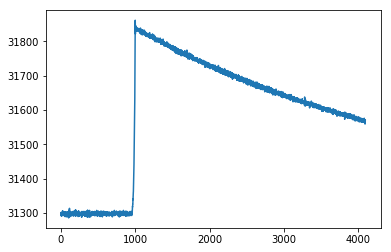

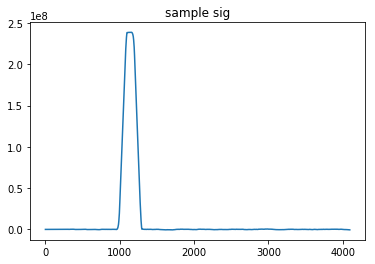

2.38843e+08
('gain = ', 1.0)


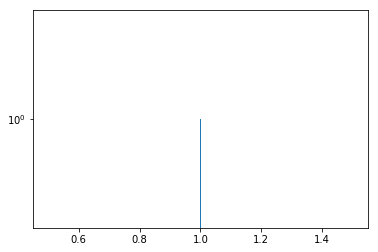

In [78]:

if __name__ == "__main__":

    filename = './DATA_co60_2.h5'
    hf = tables.open_file(filename, "r")

    event_data = hf.root.EventData.read()
    raw_data = hf.root.RawData.read()
    hf.close()

    sampling_time = 10.0
    n_data = 4096
    x_values = np.linspace(0, n_data, n_data)
    print("XVAL" , len(x_values))

    k = 100 # peaking
    m = 100 # gap
    raw_signal = raw_data[2,:]
    print("RAW ", len(raw_signal))
    plt.plot(x_values, raw_signal)
    signal = baseline_correction(raw_signal)
    signal = trapezoidal_filter_2(signal, m, k)

    plt.figure(41)
    plt.cla()
    plt.clf()
    plt.plot(x_values, signal)
    plt.title('sample sig')
    plt.show()

    energy = get_energy_value(signal)
    print(energy)

    nrgs_2 = []
    number_of_events = len(raw_data)
    number_of_events = 1
    assert number_of_events < len(raw_data)
    k = 100 # peaking time
    l = 100 # gap

    for i in range(0, number_of_events, 1):
        gap = 100
        peak = 100
        signal = raw_data[i,:]
        signal = baseline_correction(signal)
        maxval = max(signal)
        signal = signal / maxval
        signal = trapezoidal_filter_2(signal, gap, peak)
        signal = signal / 424829.69
        print('gain = ', max(signal))
        nrg = get_energy_value(signal)
        #nrg = filter_and_get_energy(raw_data[i,:], gap, peak)
        nrgs_2.append(round(nrg, 7))



    plt.hist(nrgs_2, 500, log=True)
    plt.show()

In [ ]:
print(len(raw_data))
plt.hist(nrgs_2, 500, log=True, range=(min(nrgs_2), max(nrgs_2)))
plt.show()

In [ ]:
filename = './DATA_co60_2.h5'
hf = tables.open_file(filename, "r")

event_data = hf.root.EventData.read()
raw_data = hf.root.RawData.read()
hf.close()

sampling_time = 10.0
n_data = 4096
x_values = np.linspace(0, n_data, n_data)
print("XVAL" , len(x_values))

k = 100 # peaking
m = 100 # gap
nrgsraw = []
for i in range(0, 10, 1):
    raw_signal = raw_data[i,:]
    
    #plt.plot(x_values, raw_signal)
    signal = baseline_correction(raw_signal)
    #nrgsraw.append(max(signal))
    signal = trapezoidal_filter_2(signal, m, k)
    nrgsraw.append(max(signal))
    plt.figure(41)
    plt.plot(x_values, signal)
plt.title('sample sig')
plt.xlim((1090, 1110))
plt.ylim((2.38350*10**8, 2.38450*10**8))
plt.show()

plt.hist(nrgsraw)
plt.show()